Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os


In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10

In [ ]:
def load_batch(file_path, label_key='labels'):
    """Load a batch of CIFAR data"""
    with open(file_path, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels


def load_data(path):
    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 32, 32, 3), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        batch_file_path = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(batch_file_path)
        
    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))
    
    # x_train_local = x_train_local.transpose(0, 2, 3, 1)
    # x_test_local = x_test_local.transpose(0, 2, 3, 1)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)

In [ ]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
path = 'cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_data(path)

print("Train data (x_train): ", x_train.shape)
print("Train labels (y_train): ", y_train.shape)
print("Test data (x_test): ", x_test.shape)
print("Test labels (y_test): ", y_test.shape)

In [ ]:
label = ["" for _ in range(10)]
label[0]="airplane"
label[1]="automobile"
label[2]="bird"
label[3]="cat"
label[4]="deer"
label[5]="dog"
label[6]="frog"
label[7]="horse"
label[8]="ship"
label[9]="truck"

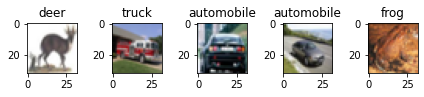

In [ ]:
num_plot = 5
figure, axes = plt.subplots(1, num_plot)
for i, ax in enumerate(axes.flat):
    img_id = np.random.randint(0, x_train.shape[0])
    ax.imshow(x_train[img_id])
    ax.set_title(label[y_train[img_id][0]])


figure.tight_layout()
figure.set_facecolor('w')
plt.show()

In [ ]:
def filter_class(class_name):
    idx = (y_train == label.index(class_name)).reshape(x_train.shape[0])
    x_train_filter = x_train[idx]
    y_train_filter = y_train[idx]
    
    idx = (y_test == label.index(class_name)).reshape(x_test.shape[0])
    x_test_filter = x_test[idx]
    y_test_filter = y_test[idx]
    
    return (x_train_filter, y_train_filter), (x_test_filter, y_test_filter)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
def euclidean_distance(image1, image2):
    gray1 = rgb2gray(image1)
    gray2 = rgb2gray(image2)
    
    distance = gray1 - gray2
    distance_squared = distance ** 2
    
    return np.sqrt(np.sum(distance_squared))

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
        else:
            classLabel=classLabels[2]   
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen = ImageDataGenerator(
                rescale=1./255,
        		zoom_range=0.20,
            	fill_mode="nearest"
                )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
            validation_path,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode=None,  # only data, no labels
            shuffle=False)   
   
    # fit model
    history=model.fit_generator(train_generator, 
                        epochs=epoch)
    
    predictions = model.predict_generator(validation_generator, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

In [ ]:
print("==============TEST RESULTS============")
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model.save(MODEL_FILENAME)